In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import rebound
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import time 
import rebound
from celmech.disturbing_function import *
import numpy as np
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech import Andoyer, AndoyerHamiltonian
from celmech.resonances import resonant_period_ratios, resonance_intersections_list, resonance_pratio_span
from rebound.plotting import OrbitPlotOneSlice
import itertools
import time

%matplotlib inline

# Can skip this. This is just to find the total integration time for the Nbody in Ari's simulations

In [14]:
path = '/mnt/raid-cita/asilburt/stability_predict/'
system = "KOI-2086"    #KOI-0156, KOI-0168, KOI-2086, Kepler-431
suffix = ''
columns = ["name","id","shadow","maxorbs","P1","time","dE","elapsed_time"]
Nbody = pd.read_csv(path+"systems/%s_Nbodyresults%s.csv"%(system,suffix),names=columns)

In [15]:
Nbody['time'].max()/3600/2 # includes shadow systems, so only calc time for non shadow

17056.180555555555

# Hey Ari, is this the right way to get the final times from the Nbody simulations? From here to plot below

# Christian, here you would load your own simulations. Just make sure you load them in the same order here as when generating the ML features below to match up the two

## Plot Stability Predictions
These are not Nbody results, these are predictions!

In [2]:
aripath = '/mnt/raid-cita/asilburt/stability_predict/simulation_archives/KOI-2086_2/'

In [3]:
import os
Nsims = 500
tfinals = np.zeros(Nsims)
sims = []
for i in range(Nsims):
    filename = os.path.join(aripath, "KOI-2086_1e9orbits_id{0}_shadow0_SA.bin".format(i))
    sa = rebound.SimulationArchive(filename)
    sim = sa[0]
    sims.append(sim)
    P1 = sim.particles[1].P
    simf = sa[-1]
    tfinals[i] = simf.t/P1

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:83: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/rebound/simulationarchive.py:127: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


In [4]:
stablemask = tfinals > 9.99e8
stablemask.sum()

476

In [5]:
unstablemask = tfinals < 9.99e8
unstablemask.sum()

24

In [7]:
Nout = len(sims)
h = np.zeros(Nout)
k = np.zeros(Nout)
for i, sim in enumerate(sims):
    try:
        p2 = sim.particles[2]
        h[i] = p2.e*np.sin(p2.pomega)
        k[i] = p2.e*np.cos(p2.pomega)
    except:
        h[i] = np.nan
        k[i] = np.nan

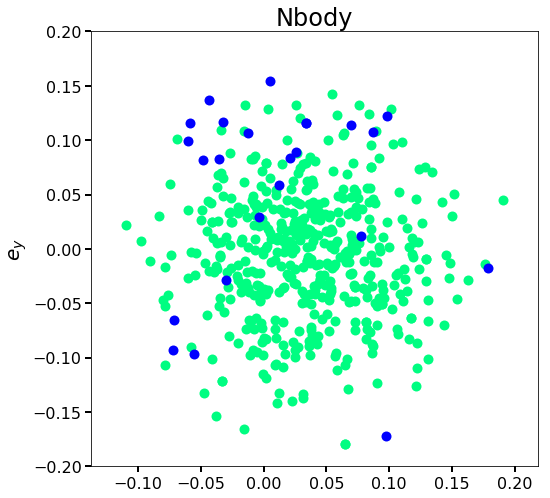

In [9]:
import matplotlib
plt.style.use('paper')
colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, ax1 = plt.subplots(figsize=[8, 8])
ax1.scatter(h[stablemask], k[stablemask], c=cmap(0.99), lw=0, label='Stable')
ax1.scatter(h[unstablemask], k[unstablemask], c=cmap(0.), lw=0, label='Unstable')

ax1.set_ylim([-0.2, 0.2])
ax1.set_ylabel(r'$e_y$') 
ax1.set_title("Nbody")

# Now make machine learning predictions

Change path to where you have your repo.

This has a copy of the functions to generate the features used in the model (should be improved, but should work with the csv files we have now to train models). You'll have to change the run function below to load the appropriate simulation.

In [36]:
import dill
modelpath = '/mnt/raid-cita/dtamayo/MLstability/Analysis/newmodels/'
model, features = dill.load(open(modelpath+"resmodel.pkl", 'rb'))

In [22]:
columns = ['featgentime', 'Zcross12', 'Zcross13', 'Zcross23', 'maxj', 'maxk', 'maxi1', 'maxi2', 'maxstrength', 'secondres', 'tlyap']
for i, s in zip([0,2], ['12', '23']): # take adjacent ones
    columns += ['EMmed'+s, 'EMmax'+s, 'EMdrift'+s, 'capseculartscale'+s, 'EMdetrendedstd'+s, 'EMrollingstd'+s, 'DiffcoeffEM'+s, 'medvarEM'+s, 'Zmed'+s, 'Zmax'+s, 'Zdetrendedstd'+s, 'Zrollingstd'+s, 'DiffcoeffZ'+s, 'medvarZ'+s, 'Zcomdrift'+s, 'Zcomrollingstd'+s, 'phiZcomdrift'+s, 'phiZcomrollingstd'+s, 'Zstardrift'+s, 'Zstarrollingstd'+s, 'Zcosphistd'+s, 'medZcosphi'+s]

In [23]:
def chunkify(lst,n):
    return [lst[i::n] for i in range(n)]

In [24]:
def worker(df):
    Ndump=5
    for i in range(df.shape[0]):
        #try:
        run(df, i, tmax=1.e4)
        #except:
        #    for col in columns:
        #        df.loc[df.index[i], col] = np.nan
        if i%Ndump == 0:
            df.to_csv('tempcsvs/'+str(os.getpid())+'.csv', encoding='ascii')
    df.to_csv('tempcsvs/'+str(os.getpid())+'.csv', encoding='ascii')

In [25]:
def findres(sim, i1, i2):
    delta = 0.03
    maxorder = 2
    ps = Poincare.from_Simulation(sim=sim).particles # get averaged mean motions
    n1 = ps[i1].n
    n2 = ps[i2].n
    
    m1 = ps[i1].m
    m2 = ps[i2].m
    
    Pratio = n2/n1
    res = resonant_period_ratios(Pratio-delta,Pratio+delta, order=maxorder)
    
    Z = np.sqrt((ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega))**2 + (ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega))**2)
    
    maxstrength = 0
    j, k, i1, i2, strength = -1, -1, -1, -1, -1
    for a, b in res:
        s = np.abs(np.sqrt(m1+m2)*Z**((b-a)/2.)/(b*n2 - a*n1))
        #print('{0}:{1}'.format(b, a), (b*n2 - a*n1), s)
        if s > maxstrength:
            j = b
            k = b-a
            i1 = 1
            i2 = 2
            strength=s
            maxstrength = s
            
    return j, k, strength

# This function needs to be modified to load the right simulation given the passed index for the simulation's ID. See more below

In [26]:
def run(df, index, tmax=1.e4, runcel=False):
    t0 = time.time()
    aripath = '/mnt/raid-cita/asilburt/stability_predict/simulation_archives/KOI-2086_2/'
    filename = os.path.join(aripath, "KOI-2086_1e9orbits_id{0}_shadow0_SA.bin".format(index))
    sa = rebound.SimulationArchive(filename)
    sim = sa[0]
    #file = path+"sa{0:07d}.bin".format(df.loc[df.index[index], 'runstring'])
    #sim = sims[index]
    ps = sim.particles
    sim.init_megno()
    
    N = sim.N - sim.N_var
    a0 = [0] + [sim.particles[i].a for i in range(1, N)]
    Npairs = int((N-1)*(N-2)/2)
    js, ks, strengths = np.zeros(Npairs, dtype=np.int), np.zeros(Npairs, dtype=np.int), np.zeros(Npairs)
    maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = -1, -1, -1, -1, -1, -1

    Zcross = np.zeros(Npairs)
    #print('pairindex, i1, i2, j, k, strength')
    for i, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
        js[i], ks[i], strengths[i] = findres(sim, i1, i2)
        Zcross[i] = (ps[int(i2)].a-ps[int(i1)].a)/ps[int(i1)].a
        #print(i, i1, i2, js[i], ks[i], strengths[i])
        if strengths[i] > maxstrength:
            maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength = js[i], ks[i], i1, i2, i, strengths[i]
    
    df.loc[df.index[index], 'Zcross12'] = Zcross[0]
    df.loc[df.index[index], 'Zcross13'] = Zcross[1]
    df.loc[df.index[index], 'Zcross23'] = Zcross[2]
    df.loc[df.index[index], 'maxj'] = maxj
    df.loc[df.index[index], 'maxk'] = maxk
    df.loc[df.index[index], 'maxi1'] = maxi1
    df.loc[df.index[index], 'maxi2'] = maxi2
    df.loc[df.index[index], 'maxstrength'] = maxstrength
    
    sortedstrengths = strengths.copy()
    sortedstrengths.sort()
    if sortedstrengths[-1] > 0 and sortedstrengths[-2] > 0:
        df.loc[df.index[index], 'secondres'] = sortedstrengths[-2]/sortedstrengths[-1]
    else:
        df.loc[df.index[index], 'secondres'] = -1
        
    if maxstrength > 0 and runcel is True:
        #print(maxj, maxk, maxi1, maxi2, maxstrength)
        andvars = Andoyer.from_Simulation(sim=sim, j=maxj, k=maxk, a10=a0[maxi1], i1=maxi1, i2=maxi2)
        H = AndoyerHamiltonian(andvars)
        #print(maxj, maxk, maxi1, maxi2, H.state.phi)
    else:
        H = None

    #print('max', maxi1, maxi2, maxj, maxk, maxpairindex, maxstrength)
    #print('df (j, k, pairindex):', df.loc[df.index[index], 'j'], df.loc[df.index[index], 'k'], df.loc[df.index[index], 'pairindex'])

    Nout = 1000
    times = np.linspace(0, tmax, Nout)

    eminus = np.zeros((Npairs, Nout))
    rebound_Z, rebound_phi = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zcom, rebound_phiZcom = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    rebound_Zstar, rebound_dKprime = np.zeros((Npairs,Nout)), np.zeros((Npairs,Nout))
    celmech_Z, celmech_phi = np.zeros(Nout), np.zeros(Nout)
    celmech_Zcom, celmech_phiZcom = np.zeros(Nout), np.zeros(Nout)
    celmech_Zstar, celmech_dKprime = np.zeros(Nout), np.zeros(Nout)

    for i,t in enumerate(times):
        for j, [i1, i2] in enumerate(itertools.combinations(np.arange(1, N), 2)):
            i1, i2 = int(i1), int(i2)
            eminus[j, i] = np.sqrt((ps[i2].e*np.cos(ps[i2].pomega)-ps[i1].e*np.cos(ps[i1].pomega))**2 + (ps[i2].e*np.sin(ps[i2].pomega)-ps[i1].e*np.sin(ps[i1].pomega))**2)
            if js[j] != -1:
                avars = Andoyer.from_Simulation(sim=sim, j=js[j], k=ks[j], a10=a0[i1], i1=i1, i2=i2)
                rebound_Z[j, i] = avars.Z
                rebound_phi[j, i] = avars.phi
                rebound_Zcom[j, i] = avars.Zcom
                rebound_phiZcom[j, i] = avars.phiZcom
                rebound_Zstar[j, i] = avars.Zstar
                rebound_dKprime[j, i] = avars.dKprime
        
        if maxstrength > 0 and runcel is True:
            celmech_Z[i] = H.state.Z
            celmech_phi[i] = H.state.phi
            celmech_Zcom[i] = H.state.Zcom
            celmech_phiZcom[i] = H.state.phiZcom
            celmech_Zstar[i] = H.state.Zstar
            celmech_dKprime[i] = H.state.dKprime

            H.integrate(t)
        try:
            sim.integrate(t)
        except:
            break
        
    mask = eminus[0] > 0 # where there are data points in case sim ends early
    times = times[mask]
    eminus = eminus[:, mask]
    rebound_Z, rebound_phi = rebound_Z[:, mask], rebound_phi[:, mask]
    rebound_Zcom, rebound_phiZcom =  rebound_Zcom[:, mask], rebound_phiZcom[:, mask]
    rebound_Zstar, rebound_dKprime = rebound_Zstar[:, mask], rebound_dKprime[:, mask]
    celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom = celmech_Z[mask], celmech_phi[mask], celmech_Zcom[mask], celmech_phiZcom[mask]
    celmech_Zstar, celmech_dKprime = celmech_Zstar[mask], celmech_dKprime[mask]
    
    for i, s in zip([0,2], ['12', '23']): # take adjacent ones
        EM = eminus[i]
        Zc = Zcross[i]
        df.loc[df.index[index], 'EMmed'+s] = np.median(EM)/Zc
        df.loc[df.index[index], 'EMmax'+s] = EM.max()/Zc
        p = np.poly1d(np.polyfit(times, EM, 3))
        m = p(times)
        EMdrift = np.abs((m[-1]-m[0])/m[0])
        df.loc[df.index[index], 'EMdrift'+s] = EMdrift
        maxindex = (m == m.max()).nonzero()[0][0] # index where cubic polynomial fit to EM reaches max to track long wavelength variations (secular?)
        if EMdrift > 0.1 and (maxindex < 0.01*Nout or maxindex > 0.99*Nout): # don't flag as not capturing secular if Z isn't varying significantly in first place
            df.loc[df.index[index], 'capseculartscale'+s] = 0
        else:
            df.loc[df.index[index], 'capseculartscale'+s] = 1
        df.loc[df.index[index], 'EMdetrendedstd'+s] = pd.Series(EM-m).std()/EM[0]
        rollstd = pd.rolling_std(EM, window=100)
        df.loc[df.index[index], 'EMrollingstd'+s] = np.median(rollstd[100:])/EM[0]
        var = [EM[:j].var() for j in range(len(EM))]
        p = np.poly1d(np.polyfit(times[len(var)//2:], var[len(var)//2:], 1)) # fit only second half to get rid of transient
        df.loc[df.index[index], 'DiffcoeffEM'+s] = p[1]/Zc**2
        df.loc[df.index[index], 'medvarEM'+s] = np.median(var[len(var)//2:])/Zc**2
        if strengths[i] != -1:
            Z = rebound_Z[i]
            df.loc[df.index[index], 'Zmed'+s] = np.median(Z)/Zc
            df.loc[df.index[index], 'Zmax'+s] = rebound_Z[i].max()/Zc
            p = np.poly1d(np.polyfit(times, Z, 3))
            m = p(times)
            df.loc[df.index[index], 'Zdetrendedstd'+s] = pd.Series(Z-m).std()/Z[0]
            rollstd = pd.rolling_std(Z, window=100)
            df.loc[df.index[index], 'Zrollingstd'+s] = np.median(rollstd[100:])/Z[0]
            var = [Z[:j].var() for j in range(len(Z))]
            p = np.poly1d(np.polyfit(times[len(var)//2:], var[len(var)//2:], 1)) # fit only second half to get rid of transient
            df.loc[df.index[index], 'DiffcoeffZ'+s] = p[1]/Zc**2
            df.loc[df.index[index], 'medvarZ'+s] = np.median(var[len(var)//2:])/Zc**2
            df.loc[df.index[index], 'Zcomdrift'+s] = np.max(np.abs(rebound_Zcom[i]-rebound_Zcom[i, 0])/rebound_Zcom[i, 0])
            rollstd = pd.rolling_std(rebound_Zcom[i], window=100)
            df.loc[df.index[index], 'Zcomrollingstd'+s] = np.median(rollstd[100:])/rebound_Zcom[i,0]
            df.loc[df.index[index], 'phiZcomdrift'+s] = np.max(np.abs(rebound_phiZcom[i]-rebound_phiZcom[i, 0]))
            rollstd = pd.rolling_std(rebound_phiZcom[i], window=100)
            df.loc[df.index[index], 'phiZcomrollingstd'+s] = np.median(rollstd[100:])
            df.loc[df.index[index], 'Zstardrift'+s] = np.max(np.abs(rebound_Zstar[i]-rebound_Zstar[i, 0])/rebound_Zstar[i, 0])
            rollstd = pd.rolling_std(rebound_Zcom[i], window=100)
            df.loc[df.index[index], 'Zstarrollingstd'+s] = np.median(rollstd[100:])/rebound_Zstar[i,0]
            Zcosphi = Z*np.cos(rebound_phi[i])
            df.loc[df.index[index], 'Zcosphistd'+s] = Zcosphi.std()/Zc
            df.loc[df.index[index], 'medZcosphi'+s] = np.median(Zcosphi)/Zc
    df.loc[df.index[index], 'tlyap'] = 1/sim.calculate_lyapunov()
    df.loc[df.index[index], 'featgentime'] = time.time()-t0
    return sim, times, maxj, maxk, maxi1, maxi2, maxpairindex, maxstrength, Npairs, js, ks, strengths, eminus, rebound_Z, rebound_phi, rebound_Zcom, rebound_phiZcom, rebound_Zstar, rebound_dKprime, celmech_Z, celmech_phi, celmech_Zcom, celmech_phiZcom, celmech_Zstar, celmech_dKprime, Zcross

# Choose a filename and make a blank dataframe with all the features we need to generate. This assumes that we have added all the REBOUND simulations into a 'sims' list, so we use its length to generate all the IDs. Modify if necessary

In [11]:
featuresfile='2086features.csv'

In [28]:
df = pd.DataFrame()
df['SimID'] = np.arange(len(sims))
for col in columns:
    df[col] = 0
df.set_index('SimID', inplace=True)

df.tail()

,featgentime,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df.to_csv(featuresfile, encoding='ascii')

# Change Nworkers to number of cores you have on your computer

In [30]:
Nworkers=60
df = pd.read_csv(featuresfile, index_col=0)
df.tail()

,featgentime,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# This separates the full dataframe into N=Nworkers dataframes to parallelize over

In [31]:
df = df[df['featgentime'] == 0.]
print(df.shape)
IDs = df.index.values
splits = chunkify(IDs, Nworkers)
dfs = [df.loc[split] for split in splits]

(500, 55)


# Run

In [32]:
from rebound import InterruptiblePool
import time
pool = InterruptiblePool(Nworkers)
pool.map(worker, dfs)

/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np

/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/celmech/celmech/andoyer.py:31: RuntimeWarning: invalid value encountered in sqrt
  Xstarres = -0.5*np.sqrt(3.*Phiprime+2.)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/mnt/raid-cita/dtamayo/stab

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: Fut

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:136: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid val

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be remove

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipyker

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:136: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_st

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:136: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_st

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:116: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: Fut

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:136: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:139: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be remove

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:142: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:118: RuntimeWarning: Degrees of freedom <= 0 for slice
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:129: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/ipykernel_launcher.py:131: Run

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# This combines all the separate csvs into a single dataframe, and prints out how many have been populated at the end, in case of any errors. If there are errors, then any systems that would have come after won't have run. You can then rerun the cells starting from 'This separates the full', which will rerun all the ones that haven't been populated

In [33]:
import os

df = pd.read_csv(featuresfile, index_col=0)
for f in os.listdir('tempcsvs/'):
    if f[-4:] == '.csv':
        print(f)
        newdf = pd.read_csv('tempcsvs/'+f, index_col=0)
        df.update(newdf)
        
df[df['featgentime'] == 0.].shape

21093.csv
21084.csv
21095.csv
21080.csv
21061.csv
21071.csv
21075.csv
21066.csv
21085.csv
21059.csv
21064.csv
21068.csv
21072.csv
21054.csv
21060.csv
21051.csv
21082.csv
21091.csv
21065.csv
21097.csv
21056.csv
21088.csv
21067.csv
21098.csv
21053.csv
21103.csv
21083.csv
21078.csv
21081.csv
21058.csv
21047.csv
21092.csv
21102.csv
21076.csv
21077.csv
21101.csv
21086.csv
21057.csv
21096.csv
21074.csv
21052.csv
21087.csv
21050.csv
21062.csv
21105.csv
21089.csv
21104.csv
21079.csv
21094.csv
21073.csv
21049.csv
21046.csv
21100.csv
21048.csv
21070.csv
21063.csv
21055.csv
21099.csv
21090.csv
21069.csv


(0, 55)

In [34]:
df.to_csv(featuresfile, encoding='ascii')

In [12]:
df = pd.read_csv(featuresfile, index_col=0)
df.head()

,featgentime,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,DiffcoeffZ23,medvarZ23,Zcomdrift23,Zcomrollingstd23,phiZcomdrift23,phiZcomrollingstd23,Zstardrift23,Zstarrollingstd23,Zcosphistd23,medZcosphi23
SimID,,,,,,,,,,,,,,,,,,,,,
0,10.427501,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,-3.382387e-11,0.000064,0.896994,0.342035,5.204716,2.038505,0.183819,0.144074,0.008058,-0.116792
1,10.877415,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,-3.382387e-11,0.000064,0.896994,0.342035,5.204716,2.038505,0.183819,0.144074,0.008058,-0.116792
2,10.846469,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,-3.382387e-11,0.000064,0.896994,0.342035,5.204716,2.038505,0.183819,0.144074,0.008058,-0.116792
3,10.516700,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,-3.382387e-11,0.000064,0.896994,0.342035,5.204716,2.038505,0.183819,0.144074,0.008058,-0.116792
4,10.705819,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,-3.382387e-11,0.000064,0.896994,0.342035,5.204716,2.038505,0.183819,0.144074,0.008058,-0.116792


# This does post-processing on the features to make additional features that end up getting used by the new model

In [13]:
def takeone(row):
    s = '12' if row['Zcross12'] < row['Zcross23'] else '23'
    row['EMmed'] = row['EMmed'+s]
    row['EMmax'] = row['EMmax'+s]
    row['EMdrift'] = row['EMdrift'+s]
    row['EMdetrendedstd'] = row['EMdetrendedstd'+s]
    row['EMrollingstd'] = row['EMrollingstd'+s]
    row['DiffcoeffEM'] = row['DiffcoeffEM'+s]
    row['Zcomdrift'] = row['Zcomdrift'+s]
    row['Zcomrollingstd'] = row['Zcomrollingstd'+s]
    row['phiZcomdrift'] = row['phiZcomdrift'+s]
    row['phiZcomrollingstd'] = row['phiZcomrollingstd'+s]
    row['Zstardrift'] = row['Zstardrift'+s]
    row['Zstarrollingstd'] = row['Zstarrollingstd'+s]
    row['Zcosphistd'] = row['Zcosphistd'+s]
    row['medZcosphi'] = row['medZcosphi'+s]
    return row

df = df.apply(takeone, axis=1)
print(df.shape)
df.head()

(500, 69)


,featgentime,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,...,EMrollingstd,DiffcoeffEM,Zcomdrift,Zcomrollingstd,phiZcomdrift,phiZcomrollingstd,Zstardrift,Zstarrollingstd,Zcosphistd,medZcosphi
SimID,,,,,,,,,,,,,,,,,,,,,
0,10.427501,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,0.060824,-4.353290e-11,0.985725,0.282638,5.136024,1.912742,0.189607,0.126149,0.008808,-0.178435
1,10.877415,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,0.060824,-4.353290e-11,0.985725,0.282638,5.136024,1.912742,0.189607,0.126149,0.008808,-0.178435
2,10.846469,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,0.060824,-4.353290e-11,0.985725,0.282638,5.136024,1.912742,0.189607,0.126149,0.008808,-0.178435
3,10.516700,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,0.060824,-4.353290e-11,0.985725,0.282638,5.136024,1.912742,0.189607,0.126149,0.008808,-0.178435
4,10.705819,0.160541,0.406461,0.211901,5.0,1.0,1.0,2.0,0.02066,0.706952,...,0.060824,-4.353290e-11,0.985725,0.282638,5.136024,1.912742,0.189607,0.126149,0.008808,-0.178435


# Load the model and make predictions

In [14]:
import dill
modelpath = '/mnt/raid-cita/dtamayo/MLstability/Analysis/newmodels/'
model, features = dill.load(open(modelpath+"resmodel.pkl", 'rb'))

/mnt/raid-cita/dtamayo/stability2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
X = df[features]
X.head()

,maxstrength,tlyap,EMmax,EMdetrendedstd,DiffcoeffEM,Zstarrollingstd
SimID,,,,,,
0,0.02066,116536.706479,0.279285,0.06069,-4.353290e-11,0.126149
1,0.02066,87493.916930,0.279285,0.06069,-4.353290e-11,0.126149
2,0.02066,769059.553257,0.279285,0.06069,-4.353290e-11,0.126149
3,0.02066,31073.520172,0.279285,0.06069,-4.353290e-11,0.126149
4,0.02066,91616.444956,0.279285,0.06069,-4.353290e-11,0.126149


In [16]:
proba = model.predict_proba(X)[:,1]

# The .77 comes from the model training notebook. It's the threshold at which the precision = recall

In [17]:
proba = np.array(proba)
pstablemask = proba > 0.77
pstablemask.sum()

11

In [18]:
punstablemask = (proba <= 0.77)
punstablemask.sum()

489

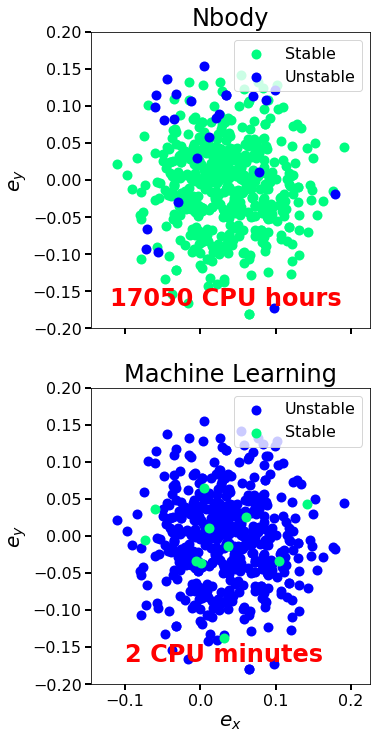

In [19]:
import matplotlib
plt.style.use('paper')
colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(2,1, figsize=[5, 12], sharex=True, sharey=True)
ax1.scatter(h[stablemask], k[stablemask], c=cmap(0.99), lw=0, label='Stable')
ax1.scatter(h[unstablemask], k[unstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[punstablemask], k[punstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[pstablemask], k[pstablemask], c=cmap(0.99), lw=0, label='Stable')


ax1.set_ylim([-0.2, 0.2])
ax1.set_ylabel(r'$e_y$') 
ax2.set_xlabel(r'$e_x$')
ax2.set_ylabel(r'$e_y$')
ax1.set_title("Nbody")
ax2.set_title("Machine Learning")

ax1.text(-0.12, -0.17, '17050 CPU hours', weight='bold', size=24, color='red')
ax2.text(-0.1, -0.17, '2 CPU minutes', weight='bold', size=24, color='red')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.savefig("NbodyvsML.png", bbox_inches="tight")

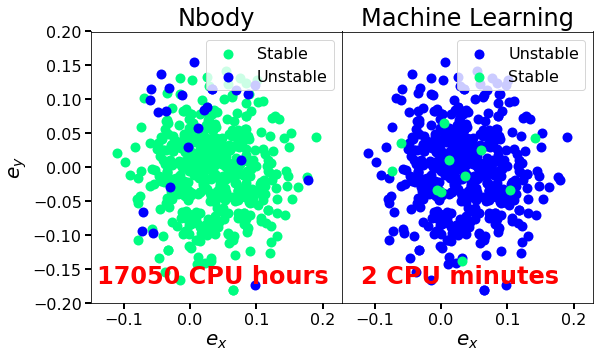

In [20]:
import matplotlib
plt.style.use('paper')
colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
f, (ax1, ax2) = plt.subplots(1,2, figsize=[9, 5], sharex=True, sharey=True)
ax1.scatter(h[stablemask], k[stablemask], c=cmap(0.99), lw=0, label='Stable')
ax1.scatter(h[unstablemask], k[unstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[punstablemask], k[punstablemask], c=cmap(0.), lw=0, label='Unstable')
ax2.scatter(h[pstablemask], k[pstablemask], c=cmap(0.99), lw=0, label='Stable')

ax1.set_ylim([-0.2, 0.2])
ax1.set_ylabel(r'$e_y$') 
ax1.set_xlabel(r'$e_x$')
ax2.set_xlabel(r'$e_x$')
ax1.set_title("Nbody")
ax2.set_title("Machine Learning")

ax1.text(-0.14, -0.17, '17050 CPU hours', weight='bold', size=24, color='red')
ax2.text(-0.12, -0.17, '2 CPU minutes', weight='bold', size=24, color='red')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.subplots_adjust(wspace=0)
ax2.tick_params(axis='y', which='both', left='off', right='off')
plt.savefig("NbodyvsML.png", bbox_inches="tight")